# Lorentz attractor — Ensemble Kalman filter

we show how easy is to extend our method to other filtering algorithms.

In [197]:
import jax
import chex
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
%config InlineBackend.figure_format = "retina"

In [222]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

## 3D loretz

In [223]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5_000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)

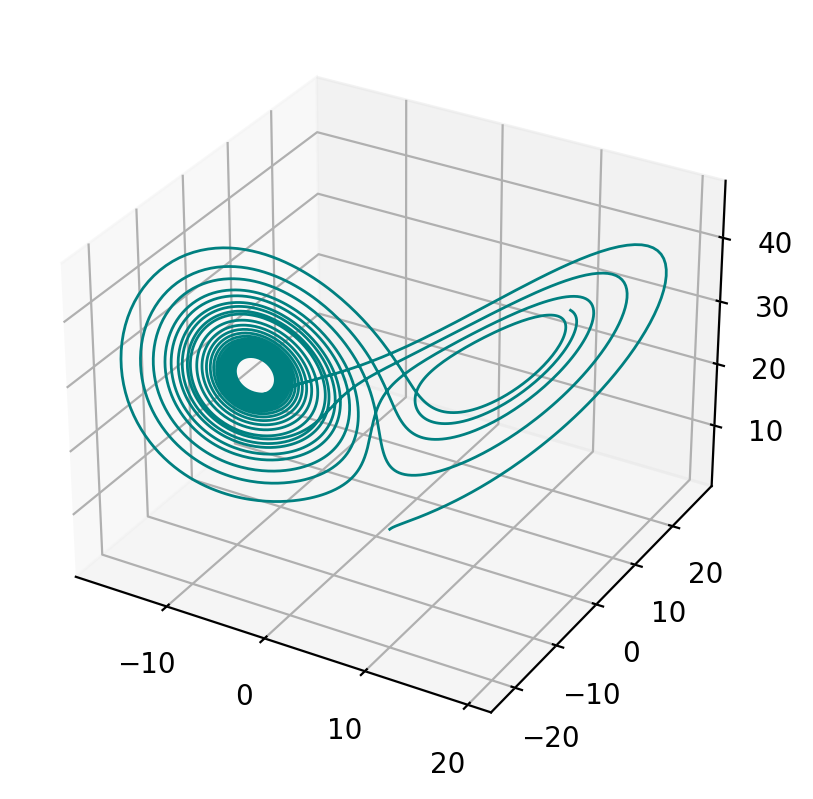

In [224]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")

# Modified Lorentz 96 model
See https://en.wikipedia.org/wiki/Lorenz_96_model


$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$
with 
* $F_k \sim {\cal N}(8, 1)$

In [299]:
D = 40
F = 8.0
ixs = jnp.arange(D)

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval = jax.random.split(key, 3)
x0 = 8.0 + jax.random.normal(key_init, (D,))

key_state, key_measurement = jax.random.split(key_sim)

In [300]:
@partial(jax.vmap, in_axes=(None, 0))
def fcoord(x, k):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, *args):
    keyt = jax.random.fold_in(key_state, t)
    F = jax.random.normal(keyt, shape=(D,)) * jnp.sqrt(0.05)
    xdot = fcoord(x, ixs) + F + 8.0
    return xdot

In [334]:
N = 60
dt = 0.05
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, dt, N, f)
ys = xs + jax.random.normal(key_measurement, xs.shape)

Text(0, 0.5, 'State at timestep $t$')

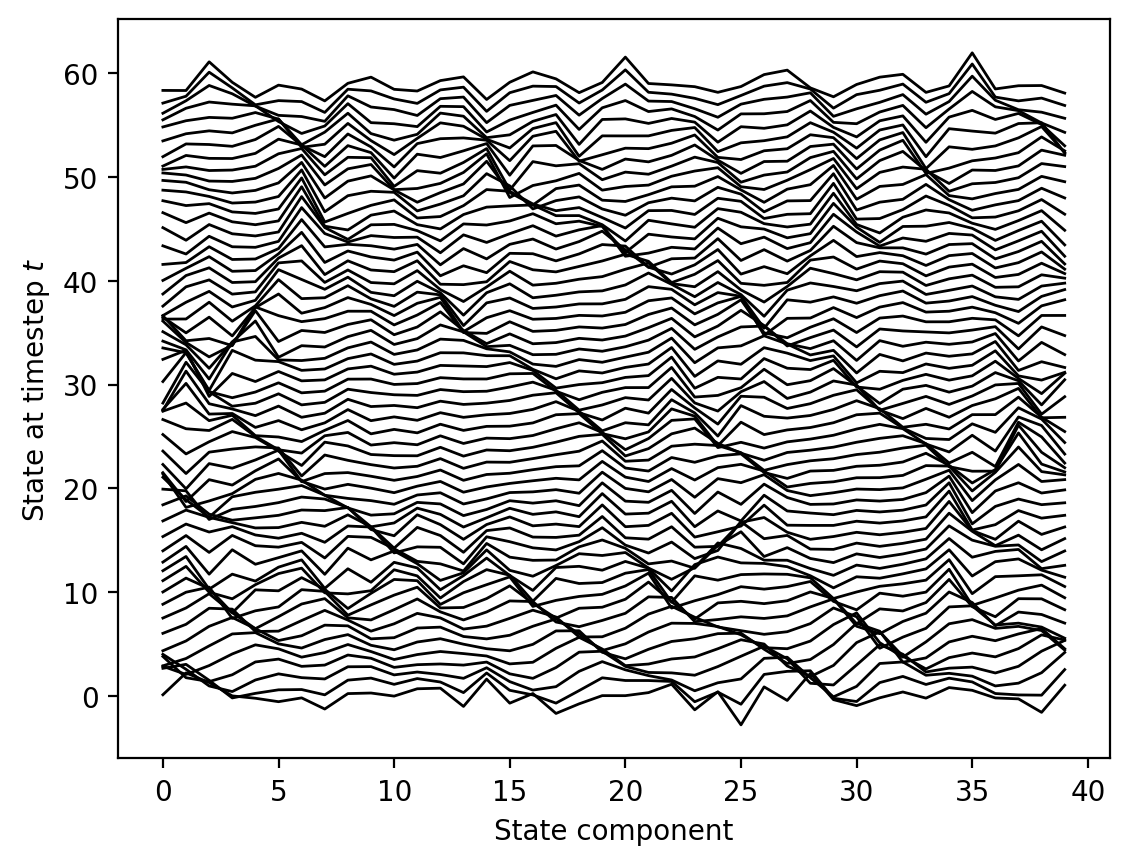

In [336]:
for i, row in enumerate(xs):
    plt.plot((row - row.mean()) / row.std() + i, c="black", linewidth=1.0, zorder=2)
    # plt.axhline(y=i, linewidth=0.5, zorder=0, c="tab:gray")
plt.xlabel("State component")
plt.ylabel("State at timestep $t$")

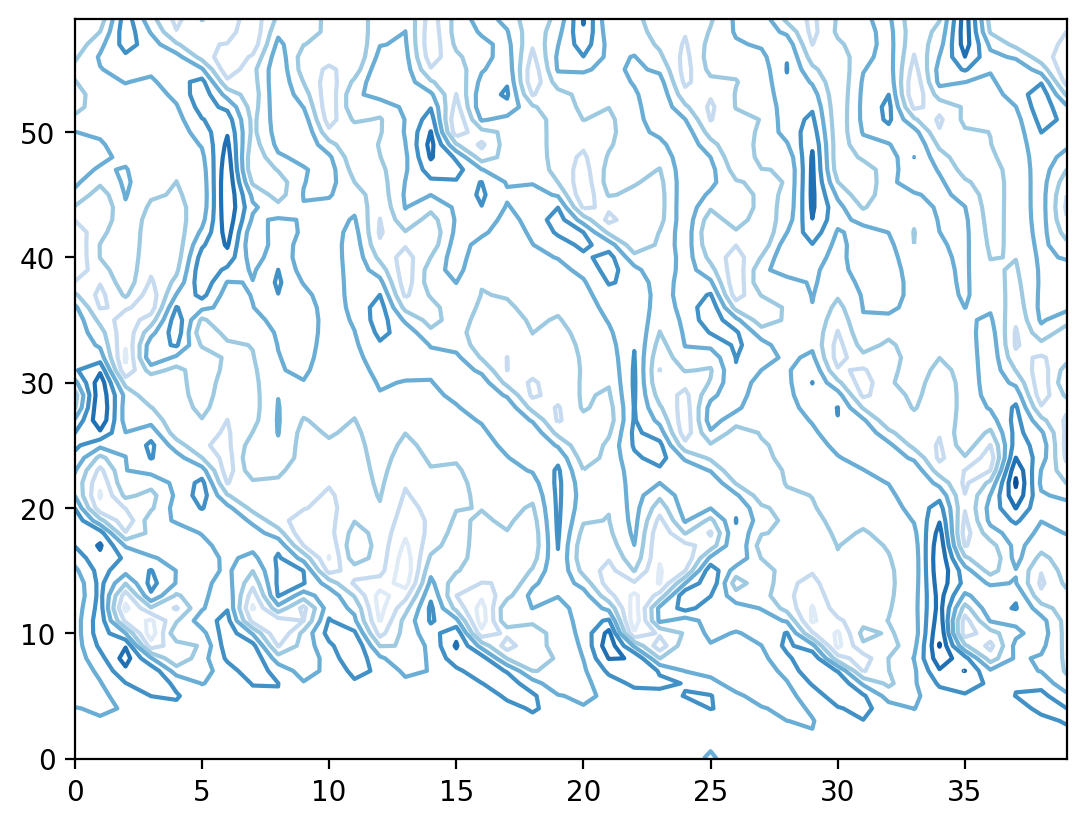

In [314]:
plt.contour(xs, cmap="Blues")

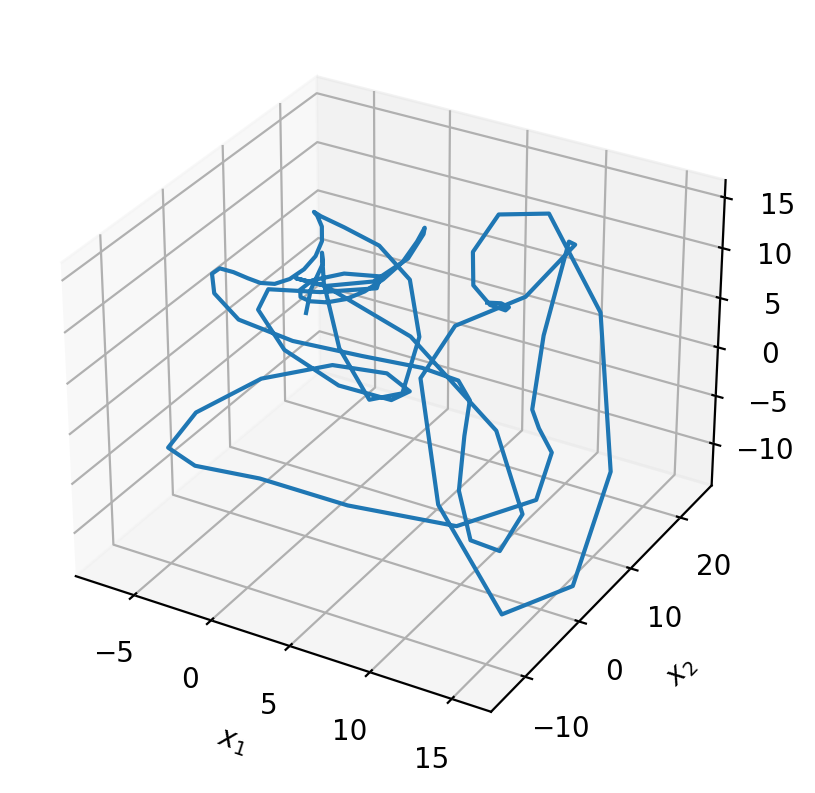

In [256]:
# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

## The ensemble Kalman filter

In [241]:
@chex.dataclass
class EnKFState:
    particles: jax.Array

In [242]:
n_particles = 100

In [243]:
X0 = jax.random.normal(key_eval, (n_particles, D))

In [244]:
dt = 0.01

In [245]:
@partial(jax.vmap, in_axes=(0, None))
def f_next(z, i):
    """
    State function
    """
    return rk4_step(z, 2 * i, dt, f)


def h_next(z, i):
    """
    Measurement function
    """
    keyt = jax.random.fold_in(key_sim, 2 * i + 1)
    keys = jax.random.split(keyt, (n_particles,))
    
    @jax.vmap
    def _next(z, key):
        err = jax.random.normal(key, (D,))
        return z + err
    
    z_next = _next(z, keys)
    return z_next

In [246]:
class EnsembleKalmanFilter:
    def __init__(self, state_fn, measurement_fn):
        self.state_fn = state_fn
        self.measurement_fn = measurement_fn
    
    def _predict(self, X, i):
        Xnext = self.state_fn(X, i)